In [1]:
!pip install sentencepiece --quiet

You should consider upgrading via the '/Users/jeremyvangansbeg/Documents/project/gsk-poc/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,AdamW
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig,TFBertModel,CamembertTokenizer, TFCamembertForSequenceClassification
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

/Users/jeremyvangansbeg/Documents/project/gsk-poc/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def encode_texts(texts, tokenizer, max_seq_length):
    input_ids = []

    encoded = tokenizer(texts,max_length=max_seq_length, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
    input_ids.append([encoded["input_ids"],encoded["attention_mask"]])
    return input_ids

def prediction(model, max_seq_length, *args) :
    texts = list(*args)
    to_test = encode_texts(texts=texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
    proba = model.predict(*to_test)
    indexes = np.argmax(proba, axis=1)
    return le.inverse_transform(indexes)

In [4]:
df = pd.read_excel(io="./data/historique_interventions_IA.xlsx", sheet_name="liste inter CATEGORISEES LIGHT")
df.columns = [title.lower().replace(" ", "_") for title in df.columns]
df.columns

Index(['description', 'activity_text', 's-ens', 'cat'], dtype='object')

In [5]:
df['s-ens_cleaned'] = df['s-ens'].str.lower()
df = df[['description','s-ens_cleaned']]
df.dropna(inplace=True)
df.columns = ['description', "labels"]

In [6]:
count = df.groupby('labels').count().reset_index()

nb_min_to_keep = 10

result = count[count['description'] > nb_min_to_keep]
result['labels']
nb_targets = result['labels'].nunique()
display(count)

,labels,description
0,autom,13
1,barre ionisante,3
2,bi,5
3,bol bouchon,25
4,cellules,61
5,climet,6
6,communication,18
7,convoyeur entrée,9
8,convoyeur principal,30
9,courroie,1


In [7]:
list_label_to_keep = result['labels'].unique()

In [8]:
df.loc[~df['labels'].isin(list_label_to_keep),"labels"] = "Autre catégorie"

In [13]:
df

,description,labels,labels_encoded
0,Surcharge convoyeur TX124,convoyeur principal,5
1,casse entree etoile entrée.,Autre catégorie,0
2,Mauvais bouchonnage,poste bouchonnage,8
3,presence bavure sur un format,Autre catégorie,0
4,Mauvais bouchonnage,poste bouchonnage,8
...,...,...,...
594,PC IPC bloqué,hmi,6
595,PB poid durant 490,Autre catégorie,0
596,Machine en attente bouchons.,poste bouchonnage,8
597,Défaut accu mini convoyeur bouchon,poste bouchonnage,8


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pickle
# Création de l'encodeur
le = LabelEncoder()
nb_targets = df['labels'].nunique()
# Entraînement de l'encodeur et transformation des labels
df['labels_encoded'] = le.fit_transform(df['labels'])

y = df['labels_encoded']


filename = './save_model/labelencoder2.pkl'
pickle.dump(le, open(filename, 'wb'))


X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(np.array(df['description']), y,
                                                   test_size=0.2,
                                                   random_state = 0,
                                                   stratify=y,
                                                   shuffle=True)
X_train_nlp, X_val_nlp, y_train_nlp, y_val_nlp = train_test_split(np.array(X_train_nlp), np.array(y_train_nlp),
                                                   test_size=0.1,
                                                   random_state = 0,
                                                   stratify=y_train_nlp,
                                                   shuffle=True)





In [10]:
from collections import Counter
import numpy as np

element_counts = Counter(y_train_nlp)

for element, count in element_counts.items():
    print(f"Element {le.inverse_transform([element])[0]} occurs {count} times.")

Element hmi occurs 65 times.
Element ipc occurs 74 times.
Element convoyeur principal  occurs 21 times.
Element autom occurs 9 times.
Element vis sans fin occurs 17 times.
Element poste bouchonnage occurs 48 times.
Element servo commande occurs 8 times.
Element communication occurs 13 times.
Element cellules  occurs 44 times.
Element Autre catégorie occurs 55 times.
Element bol bouchon occurs 18 times.
Element table tournante occurs 13 times.
Element poste remplissage occurs 20 times.
Element roue sortie  occurs 16 times.
Element tremie  occurs 9 times.


In [11]:
tokenizer = CamembertTokenizer("./save_model/tokenizer_model.model")

model = TFCamembertModel.from_pretrained("jplu/tf-camembert-base",num_labels=nb_targets)
LONGUEUR_MAX_COMMENTAIRE = df.description.str.len().max()
output_tokenizer_entrainement = tokenizer(list(X_train_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_tests = tokenizer(list(X_test_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_val = tokenizer(list(X_val_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Some layers from the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [12]:
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32')
sortie_camemBERT = model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)
model_camemBERT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [13]:
output = Dense(nb_targets, activation='softmax')(sortie_camemBERT[1])  # Use pooled representation
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs=output)
model.layers[2].trainable = False  # Disable training of CamemBERT


model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(5e-4,weight_decay= 0.01), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [14]:
class_weights = class_weight.compute_class_weight(
                    'balanced',
                    classes=np.unique(y_train_nlp),
                    y=y_train_nlp)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
liste_weight = []



In [15]:
for count, description in enumerate(X_train_nlp):
    # print(count , description,le.inverse_transform([y_train_nlp[count]])[0])
    if le.inverse_transform([y_train_nlp[count]]) != "ipc":
        if "ipc" in description.lower():
            liste_weight.append(1.25)
        else:
            liste_weight.append(1)
    else:
        liste_weight.append(0.95)
sample_weights = np.array(liste_weight).ravel()

In [16]:
# early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# callbacks=[early]
# history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
#                     epochs=20, verbose=1, batch_size = 32,callbacks=callbacks, workers=-1, sample_weight=sample_weights,
#                     validation_data=([output_tokenizer_val['input_ids'],output_tokenizer_val['attention_mask']],y_val_nlp))

Epoch 1/20
14/14 [==============================] - 18s 1s/step - loss: 2.6802 - accuracy: 0.1256 - val_loss: 2.5803 - val_accuracy: 0.1458
Epoch 2/20
14/14 [==============================] - 11s 810ms/step - loss: 2.5786 - accuracy: 0.1465 - val_loss: 2.5078 - val_accuracy: 0.1458
Epoch 3/20
14/14 [==============================] - 11s 817ms/step - loss: 2.5182 - accuracy: 0.1581 - val_loss: 2.4674 - val_accuracy: 0.1458
Epoch 4/20
14/14 [==============================] - 12s 832ms/step - loss: 2.4914 - accuracy: 0.1512 - val_loss: 2.4482 - val_accuracy: 0.1458
Epoch 5/20
14/14 [==============================] - 12s 900ms/step - loss: 2.4716 - accuracy: 0.1558 - val_loss: 2.4382 - val_accuracy: 0.1667
Epoch 6/20
14/14 [==============================] - 12s 843ms/step - loss: 2.4570 - accuracy: 0.1721 - val_loss: 2.4329 - val_accuracy: 0.2083
Epoch 7/20
14/14 [==============================] - 11s 816ms/step - loss: 2.4583 - accuracy: 0.2302 - val_loss: 2.4278 - val_accuracy: 0.2083
Ep

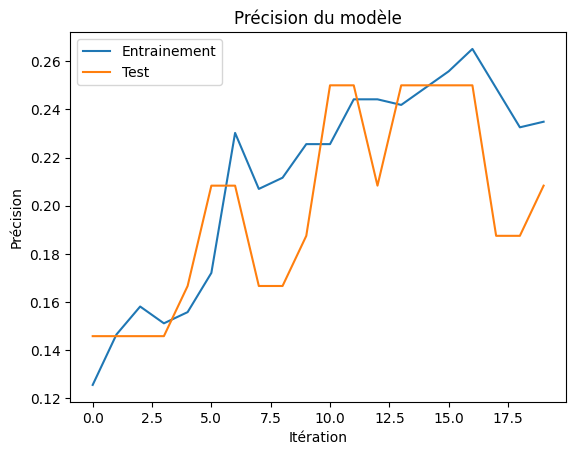

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()


In [18]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# Assuming you have trained your model and obtained predictions
# Replace this with your actual test/validation data and predictions
y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = le.transform(prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)
from sklearn.metrics import classification_report

y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

4/4 [==============================] - 5s 792ms/step
Macro F1 Score (Multi-label): 0.04603729603729604
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         6
           6       0.20      0.94      0.33        18
           7       0.29      0.48      0.36        21
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         5

    accuracy                   

/Users/jeremyvangansbeg/Documents/project/gsk-poc/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeremyvangansbeg/Documents/project/gsk-poc/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeremyvangansbeg/Documents/project/gsk-poc/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [19]:
model.layers[2].trainable = True
model.layers[3].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(1e-4,weight_decay= 0.01), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [20]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=30, verbose=1, batch_size = 32,callbacks=callbacks, workers=-1, use_multiprocessing=False,sample_weight=sample_weights,
                    validation_data=([output_tokenizer_val['input_ids'],output_tokenizer_val['attention_mask']],y_val_nlp))

Epoch 1/30
14/14 [==============================] - 52s 3s/step - loss: 2.2626 - accuracy: 0.3209 - val_loss: 1.8792 - val_accuracy: 0.4375
Epoch 2/30
14/14 [==============================] - 38s 3s/step - loss: 1.7138 - accuracy: 0.5442 - val_loss: 1.4257 - val_accuracy: 0.5625
Epoch 3/30
14/14 [==============================] - 38s 3s/step - loss: 1.1813 - accuracy: 0.7256 - val_loss: 1.2244 - val_accuracy: 0.6042
Epoch 4/30
14/14 [==============================] - 34s 2s/step - loss: 0.7550 - accuracy: 0.8721 - val_loss: 0.9965 - val_accuracy: 0.6458
Epoch 5/30
14/14 [==============================] - 34s 2s/step - loss: 0.4589 - accuracy: 0.9442 - val_loss: 0.8333 - val_accuracy: 0.7708
Epoch 6/30
14/14 [==============================] - 34s 2s/step - loss: 0.2896 - accuracy: 0.9721 - val_loss: 0.8536 - val_accuracy: 0.7500
Epoch 7/30
14/14 [==============================] - 34s 2s/step - loss: 0.1849 - accuracy: 0.9930 - val_loss: 0.8678 - val_accuracy: 0.7292
Epoch 8/30
14/14 [==

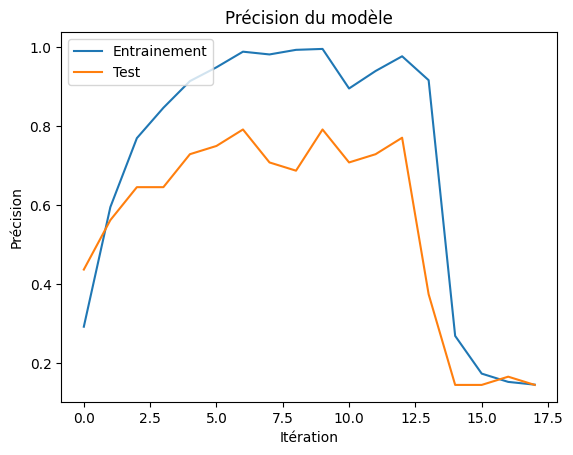

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [ ]:
test1 = 'Remplacemetn ecran IPC'
test2 = 'Ecran IPC figé'
test3 = "Perte de COM"
test4 = "Dépassement temps de pesé IPC TARE"
prediction(model, LONGUEUR_MAX_COMMENTAIRE,[test1,test2,test3,test4])

1/1 [==============================] - 0s 349ms/step


array(['ipc', 'hmi', 'communication', 'à catégoriser par un humain'],
      dtype=object)

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# Assuming you have trained your model and obtained predictions
# Replace this with your actual test/validation data and predictions
y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = le.transform(prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)
from sklearn.metrics import classification_report

y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

4/4 [==============================] - 4s 961ms/step
Macro F1 Score (Multi-label): 0.6598545659426932
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.75      0.60      0.67         5
           2       0.67      0.50      0.57        12
           3       1.00      0.75      0.86         4
           4       0.67      0.67      0.67         6
           5       0.85      0.94      0.89        18
           6       0.79      0.71      0.75        21
           7       0.75      0.69      0.72        13
           8       0.60      0.50      0.55         6
           9       1.00      0.50      0.67         4
          10       1.00      0.50      0.67         2
          11       1.00      0.67      0.80         3
          12       0.33      0.50      0.40         2
          13       0.67      0.80      0.73         5
          14       0.37      0.62      0.47        16

    accuracy                    

In [ ]:
model_path = "./save_model/"
date = datetime.now()
model.save(model_path+f"nlp_nb_class_{nb_targets}_{date}.h5")

/home/apprenant/miniconda3/envs/nlp_fail/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
custom_objects = {'TFCamembertModel': TFCamembertModel}
model_path =  "save_model/nlp_nb_class_15_2023-11-23 09 22 54.921757.h5"
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_2 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [ ]:
test1 = 'Remplacemetn ecran IPC'
test2 = 'Ecran IPC figé'
test3 = "Perte de COM"
test4 = "Dépassement temps de pesé IPC TARE"
prediction(loaded_model, LONGUEUR_MAX_COMMENTAIRE,[test1,test2,test3,test4])

1/1 [==============================] - 4s 4s/step


array(['poste bouchonnage', 'hmi', 'communication',
       'à catégoriser par un humain'], dtype=object)

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# Assuming you have trained your model and obtained predictions
# Replace this with your actual test/validation data and predictions
y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = le.transform(prediction(loaded_model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)

4/4 [==============================] - 5s 1s/step
Macro F1 Score (Multi-label): 0.6518891480784063


In [ ]:

y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      0.60      0.60         5
           2       0.55      0.50      0.52        12
           3       0.75      0.75      0.75         4
           4       0.57      0.67      0.62         6
           5       0.71      0.83      0.77        18
           6       0.70      0.76      0.73        21
           7       0.80      0.62      0.70        13
           8       0.60      0.50      0.55         6
           9       0.67      0.50      0.57         4
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         3
          12       0.50      0.50      0.50         2
          13       0.67      0.80      0.73         5
          14       0.56      0.62      0.59        16

    accuracy                           0.67       120
   macro avg       0.71      0.63      0.65       120
weighted avg       0.68   